## Setup

In [1]:
!pip install jiwer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 23.0 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from IPython import display
from jiwer import wer
from matplotlib.font_manager import FontProperties

In [ ]:
font_prop = FontProperties(fname='/content/drive/MyDrive/SLT Hackathon/Font/MANGAL.TTF')

## Load the Dataset

In [ ]:
data_path = "/content/drive/MyDrive/SLT Hackathon/Data"
wavs_path = data_path + "/Mono/sp008/"
metadata_path = data_path + "/Transcript/sp008.txt"


# Read metadata file and parse it
metadata_df = pd.read_table(metadata_path, header=None)
metadata_df.columns = ["file_name", "normalized_transcription"]
metadata_df = metadata_df.sample(frac=1).reset_index(drop=True)
metadata_df.head(3)

,file_name,normalized_transcription
0,sp008-002315_Yugavatara_04,ऐदम्प्राथम्येन हर हर महादेव इति स्वराज्यस्य रण...
1,sp008-002300_Yugavatara_04,दास्येन एव तृप्तिम् प्राप्नुवती तेषाम् मनःस्थि...
2,sp008-002118_Yugavatara_01,नमस्करोतु तम् इति


In [ ]:
metadata_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2498 entries, 0 to 2497
Data columns (total 2 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   file_name                 2498 non-null   object
 1   normalized_transcription  2498 non-null   object
dtypes: object(2)
memory usage: 39.2+ KB


In [ ]:
# To read all wav files from the data folder. glob is python function
af = tf.io.gfile.glob(wavs_path + '*.wav')

In [ ]:
len(af)

2933

We now split the data into training and validation set.

In [ ]:
split = int(len(metadata_df) * 0.90)
df_train = metadata_df[:split]
df_val = metadata_df[split:]

print(f"Size of the training set: {len(df_train)}")
print(f"Size of the training set: {len(df_val)}")


Size of the training set: 2639
Size of the training set: 294


## Preprocessing

We first prepare the vocabulary to be used.

In [ ]:
# The set of characters accepted in the transcription.
# Unicodes of sanksrit vocabulary
characters = [' ',u'\u0900',u'\u0901',u'\u0902',u'\u0903',u'\u0904',u'\u0905',u'\u0906',u'\u0907',u'\u0908',u'\u0909',u'\u090A',u'\u090B',u'\u090C',u'\u090D',u'\u090E',u'\u090F',
     u'\u0910',u'\u0911',u'\u0912',u'\u0913',u'\u0914',u'\u0915',u'\u0916',u'\u0917',u'\u0918',u'\u0919',u'\u091A',u'\u091B',u'\u091C',u'\u091D',u'\u091E',u'\u091F',
     u'\u0920',u'\u0921',u'\u0922',u'\u0923',u'\u0924',u'\u0925',u'\u0926',u'\u0927',u'\u0928',u'\u0929',u'\u092A',u'\u092B',u'\u092C',u'\u092D',u'\u092E',u'\u092F',
     u'\u0930',u'\u0931',u'\u0932',u'\u0933',u'\u0934',u'\u0935',u'\u0936',u'\u0937',u'\u0938',u'\u0939',u'\u093A',u'\u093B',u'\u093C',u'\u093D',u'\u093E',u'\u093F',
     u'\u0940',u'\u0941',u'\u0942',u'\u0943',u'\u0944',u'\u0945',u'\u0946',u'\u0947',u'\u0948',u'\u0949',u'\u094A',u'\u094B',u'\u094C',u'\u094D',u'\u094E',u'\u094F',
     u'\u0950',u'\u0951',u'\u0952',u'\u0953',u'\u0954',u'\u0955',u'\u0956',u'\u0957',u'\u0958',u'\u0959',u'\u095A',u'\u095B',u'\u095C',u'\u095D',u'\u095E',u'\u095F',
     u'\u0960',u'\u0961',u'\u0962',u'\u0963',u'\u0964',u'\u0965',u'\u0966',u'\u0967',u'\u0968',u'\u0969',u'\u096A',u'\u096B',u'\u096C',u'\u096D',u'\u096E',u'\u096F',
     u'\u0970',u'\u0971',u'\u0972',u'\u0973',u'\u0974',u'\u0975',u'\u0976',u'\u0977',u'\u0978',u'\u0979',u'\u097A',u'\u097B',u'\u097C',u'\u097D',u'\u097E',u'\u097F']  
# Mapping characters to integers
# Convert to model readable format
char_to_num = keras.layers.StringLookup(vocabulary=characters, oov_token="", encoding='utf8')
# Mapping integers back to original characters
# Model readable to unicode
num_to_char = keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True, encoding='utf8'
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', ' ', 'ऀ', 'ँ', 'ं', 'ः', 'ऄ', 'अ', 'आ', 'इ', 'ई', 'उ', 'ऊ', 'ऋ', 'ऌ', 'ऍ', 'ऎ', 'ए', 'ऐ', 'ऑ', 'ऒ', 'ओ', 'औ', 'क', 'ख', 'ग', 'घ', 'ङ', 'च', 'छ', 'ज', 'झ', 'ञ', 'ट', 'ठ', 'ड', 'ढ', 'ण', 'त', 'थ', 'द', 'ध', 'न', 'ऩ', 'प', 'फ', 'ब', 'भ', 'म', 'य', 'र', 'ऱ', 'ल', 'ळ', 'ऴ', 'व', 'श', 'ष', 'स', 'ह', 'ऺ', 'ऻ', '़', 'ऽ', 'ा', 'ि', 'ी', 'ु', 'ू', 'ृ', 'ॄ', 'ॅ', 'ॆ', 'े', 'ै', 'ॉ', 'ॊ', 'ो', 'ौ', '्', 'ॎ', 'ॏ', 'ॐ', '॑', '॒', '॓', '॔', 'ॕ', 'ॖ', 'ॗ', 'क़', 'ख़', 'ग़', 'ज़', 'ड़', 'ढ़', 'फ़', 'य़', 'ॠ', 'ॡ', 'ॢ', 'ॣ', '।', '॥', '०', '१', '२', '३', '४', '५', '६', '७', '८', '९', '॰', 'ॱ', 'ॲ', 'ॳ', 'ॴ', 'ॵ', 'ॶ', 'ॷ', 'ॸ', 'ॹ', 'ॺ', 'ॻ', 'ॼ', 'ॽ', 'ॾ', 'ॿ'] (size =130)


Next, we create the function that describes the transformation that we apply to each
element of our dataset.

In [ ]:
# USed for audio

# An integer scalar Tensor. The window length in samples.
# Frame size to divide whole audio clip into
frame_length = 256
# An integer scalar Tensor. The number of samples to step.
# SLiding window size
frame_step = 160
# An integer scalar Tensor. The size of the FFT to apply.
# If not provided, uses the smallest power of 2 enclosing frame_length.
# Hyperparameter gueesed after 5-6 attempts
fft_length = 384


def encode_single_sample(wav_file, label):
    ###########################################
    ##  Process the Audio
    ##########################################
    # 1. Read wav file
    file = tf.io.read_file(wavs_path + wav_file + ".wav")
    # 2. Decode the wav file
    audio, _ = tf.audio.decode_wav(file)
    audio = tf.squeeze(audio, axis=-1)
    # 3. Change type to float
    audio = tf.cast(audio, tf.float32)
    # 4. Get the spectrogram
    spectrogram = tf.signal.stft(
        audio, frame_length=frame_length, frame_step=frame_step, fft_length=fft_length
    )
    # 5. We only need the magnitude, which can be derived by applying tf.abs
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.math.pow(spectrogram, 0.5)
    # 6. normalisation
    means = tf.math.reduce_mean(spectrogram, 1, keepdims=True)
    stddevs = tf.math.reduce_std(spectrogram, 1, keepdims=True)
    spectrogram = (spectrogram - means) / (stddevs + 1e-10)
    ###########################################
    ##  Process the label
    ##########################################
    # 8. Split the label
    label = tf.strings.unicode_split(label, input_encoding="UTF-8")
    # 9. Map the characters in label to numbers
    label = char_to_num(label)
    # 10. Return a dict as our model is expecting two inputs
    return spectrogram, label


## Creating `Dataset` objects

We create a `tf.data.Dataset` object that yields
the transformed elements, in the same order as they
appeared in the input.

In [ ]:
# Reason for 32, it worked best in our given training env which was colab pro
batch_size = 32
# Define the trainig dataset
train_dataset = tf.data.Dataset.from_tensor_slices(
    (list(df_train["file_name"]), list(df_train["normalized_transcription"]))
)
train_dataset = (
    train_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

# Define the validation dataset
validation_dataset = tf.data.Dataset.from_tensor_slices(
    (list(df_val["file_name"]), list(df_val["normalized_transcription"]))
)
validation_dataset = (
    validation_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

## Visualize the data

Let's visualize an example in our dataset, including the
audio clip, the spectrogram and the corresponding label.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 108 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 112 missing from current font.
  font.set_text(s, 0.0, flags=flags)


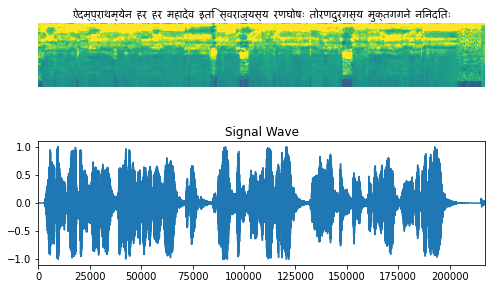

In [ ]:
fig = plt.figure(figsize=(8, 5))
for batch in train_dataset.take(1):
    spectrogram = batch[0][0].numpy()
    spectrogram = np.array([np.trim_zeros(x) for x in np.transpose(spectrogram)])
    label = batch[1][0]
    # Spectrogram
    label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
    ax = plt.subplot(2, 1, 1)
    ax.imshow(spectrogram, vmax=1)
    ax.set_title(label, fontproperties=font_prop)
    ax.axis("off")
    # Wav
    file = tf.io.read_file(wavs_path + list(df_train["file_name"])[0] + ".wav")
    audio, _ = tf.audio.decode_wav(file)
    audio = audio.numpy()
    ax = plt.subplot(2, 1, 2)
    plt.plot(audio)
    ax.set_title("Signal Wave")
    ax.set_xlim(0, len(audio))
    display.display(display.Audio(np.transpose(audio), rate=16000))
plt.show()

## Model

We first define the CTC Loss function.

In [ ]:
def CTCLoss(y_true, y_pred):
    # Compute the training-time loss value
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss


We now define our model. We will define a model similar to
[DeepSpeech2](https://nvidia.github.io/OpenSeq2Seq/html/speech-recognition/deepspeech2.html).

In [ ]:
def build_model(input_dim, output_dim, rnn_layers=5, rnn_units=128):
    
    # Model's input
    input_spectrogram = layers.Input((None, input_dim), name="input")

    # Expand the dimension to use 2D CNN.
    x = layers.Reshape((-1, input_dim, 1), name="expand_dim")(input_spectrogram)
    
    # Convolution layer 1
    x = layers.Conv2D(filters=32, kernel_size=[11, 41], strides=[2, 2], padding="same", use_bias=False, name="conv_1")(x)
    x = layers.BatchNormalization(name="conv_1_bn")(x)
    x = layers.ReLU(name="conv_1_relu")(x)

    # Convolution layer 2
    x = layers.Conv2D(filters=32, kernel_size=[11, 21], strides=[1, 2], padding="same", use_bias=False, name="conv_2")(x)
    x = layers.BatchNormalization(name="conv_2_bn")(x)
    x = layers.ReLU(name="conv_2_relu")(x)

    # Reshape the resulted volume to feed the RNNs layers
    x = layers.Reshape((-1, x.shape[-2] * x.shape[-1]))(x)

    # RNN layers
    for i in range(1, rnn_layers + 1):
        recurrent = layers.GRU(units=rnn_units, activation="tanh",recurrent_activation="sigmoid",
            use_bias=True, return_sequences=True, reset_after=True, name=f"gru_{i}")
        x = layers.Bidirectional(recurrent, name=f"bidirectional_{i}", merge_mode="concat")(x)
        if i < rnn_layers:
            x = layers.Dropout(rate=0.5)(x)

    # Dense layer
    x = layers.Dense(units=rnn_units * 2, name="dense_1")(x)
    x = layers.ReLU(name="dense_1_relu")(x)
    x = layers.Dropout(rate=0.5)(x)

    # Classification layer
    output = layers.Dense(units=output_dim + 1, activation="softmax")(x)

    # Model
    model = keras.Model(input_spectrogram, output, name="team_ananta_ctc_model")

    # Optimizer
    opt = keras.optimizers.Adam(learning_rate=1e-4)
    
    # Compile the model and return
    model.compile(optimizer=opt, loss=CTCLoss)
    return model


# Get the model
model = build_model(
    input_dim=fft_length // 2 + 1,
    output_dim=char_to_num.vocabulary_size(),
    rnn_units=512,
)
model.summary(line_length=110)

## Training and Evaluating

In [ ]:
# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0]
    # Iterate over the results and get back the text
    output_text = []
    for result in results:
        result = tf.strings.reduce_join(num_to_char(result)).numpy().decode("utf-8")
        output_text.append(result)
    return output_text


# A callback class to output a few transcriptions during training
class CallbackEval(keras.callbacks.Callback):
    """Displays a batch of outputs after every epoch."""

    def __init__(self, dataset):
        super().__init__()
        self.dataset = dataset

    def on_epoch_end(self, epoch: int, logs=None):
        predictions = []
        targets = []
        for batch in self.dataset:
            X, y = batch
            batch_predictions = model.predict(X)
            batch_predictions = decode_batch_predictions(batch_predictions)
            predictions.extend(batch_predictions)
            for label in y:
                label = (
                    tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
                )
                targets.append(label)
        wer_score = wer(targets, predictions)
        print("-" * 100)
        print(f"Word Error Rate: {wer_score:.4f}")
        print("-" * 100)
        for i in np.random.randint(0, len(predictions), 2):
            print(f"Target    : {targets[i]}")
            print(f"Prediction: {predictions[i]}")
            print("-" * 100)

Let's start the training process.

In [ ]:
model = keras.models.load_model('/content/drive/MyDrive/SLT Hackathon/Saved Models/v1.1_17_4_7', custom_objects={"CTCLoss": CTCLoss})

In [ ]:
# Define the number of epochs.
# Total 125 epochs, on these 5 large data file. On small files also 5 were performed. About 200 epochs.
# 1 epoch required 2-2.5 hours
epochs = 5
# Callback function to check transcription on the val set.
validation_callback = CallbackEval(validation_dataset)
# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[validation_callback],
)

In [ ]:
model.save('/content/drive/MyDrive/SLT Hackathon/Saved Models/v1.1_17_4_7_8')

In [ ]:
# model = keras.models.load_model('/content/drive/MyDrive/SLT Hackathon/Saved Models/v1.9_12_11_15_16', custom_objects={"CTCLoss": CTCLoss})

## Inference

In [ ]:
# Let's check results on more validation samples
predictions = []
targets = []
for batch in validation_dataset:
    X, y = batch
    batch_predictions = model.predict(X)
    batch_predictions = decode_batch_predictions(batch_predictions)
    predictions.extend(batch_predictions)
    for label in y:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        targets.append(label)
wer_score = wer(targets, predictions)
print("-" * 100)
print(f"Word Error Rate: {wer_score:.4f}")
print("-" * 100)
for i in np.random.randint(0, len(predictions), 5):
    print(f"Target    : {targets[i]}")
    print(f"Prediction: {predictions[i]}")
    print("-" * 100)

1/1 [==============================] - 0s 264ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.4453
----------------------------------------------------------------------------------------------------
Target    : यैस्तथाभूतैः सद्भिः नमस्कृता वन्दिता सती सद्यः रभसेन वेगेन विमानतः विमानात्
Prediction: यैस्तथाभूतै सभ्भिः नमस्कृता वन्दिता सती सद्यः रभसेन वीगेन िमानतः िमानात्
----------------------------------------------------------------------------------------------------
Target    : अत एव योद्धुम् युद्धम् कर्तुम् स्वकरैः आत्मीयपाणिभिः उद्धृतानि गृहीतानि आयुधानि खड्गादीनि
Prediction: अत एव योद्धुम् युद्धम् कर्तुम् स्वकरैः आत्मीयपाणिभिः उद्धृतानि गृहीतानि आयिधानि खड्गादीनि
----------------------------------------------------------------------------------------------------
Target    : दध्वान ध्वनिम् चकार
Prediction: दध्वान धलिञ्चकार
---------------------------------------------------------------------------------